In [1]:
import import_ipynb

from keras.layers import Input, Dense, Concatenate, GlobalAveragePooling1D, Dropout, Lambda
from IPython.display import display, Image, update_display, HTML
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from transformer import TransformerBlock
from keras.regularizers import L1L2
import user_ad_interaction
import keras_tuner as kt
import tensorflow as tf
import pandas as pd
import numpy as np
import datetime
import users
import tools
import os

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
root_directories = ["ADS16_Benchmark_part1", "ADS16_Benchmark_part2"]

In [3]:
if __name__ == "__main__":
    tuner = tools.HyperbandWithBatchSize(
        user_ad_interaction.create_model,
        objective=kt.Objective("val_rating_mae", direction="min"),
        max_epochs=100,
        factor=3,
        hyperband_iterations=5,
        directory="user_ad_interaction_model_logs/hypertraining",
        project_name="user_ad_interaction"
    )
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    user_model = user_ad_interaction.create_model(best_hps)
    user_model.load_weights("user_ad_interaction_model_logs/checkpoints/model-000020-1.202267.hdf5")

INFO:tensorflow:Reloading Oracle from existing project user_ad_interaction_model_logs/hypertraining\user_ad_interaction\oracle.json
INFO:tensorflow:Reloading Tuner from user_ad_interaction_model_logs/hypertraining\user_ad_interaction\tuner0.json


In [4]:
if __name__ == "__main__":
    ad_ftrs, num_categories, real_user_ftrs, _ = user_ad_interaction.load_user_and_ad_ftrs(root_directories)
    user_pca_normal_params = users.approximate_normal_params(real_user_ftrs.T)
    n_ads = len(ad_ftrs[0])

    rating_to_exp_ctr = {
        1: 0.014925,
        2: 0.024786,
        3: 0.031071,
        4: 0.040562,
        5: 0.068341
    }

    n_users = 5
    n_rounds = 10
    diminishing_returns_fac = 0.9


In [5]:
if __name__ == "__main__":
    logs_dir="adgorithm_logs"
    log_dir = os.path.join(logs_dir, "fit", datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

INFO:tensorflow:Reloading Oracle from existing project adgorithm_logs\hypertraining\adgorithm_htuning\oracle.json
EXAMPLE MODEL --- HYPERPARAMS NOT TUNED
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input_stacked (InputLayer  [(None, 5, 50, 25)]  0          []                               
 )                                                                                                
                                                                                                  
 text_input_0 (Lambda)          (None, 50, 25)       0           ['text_input_stacked[0][0]']     
                                                                                                  
 text_input_1 (Lambda)          (None, 50, 25)       0           ['text_input_stacked[0][0]']     
                                     

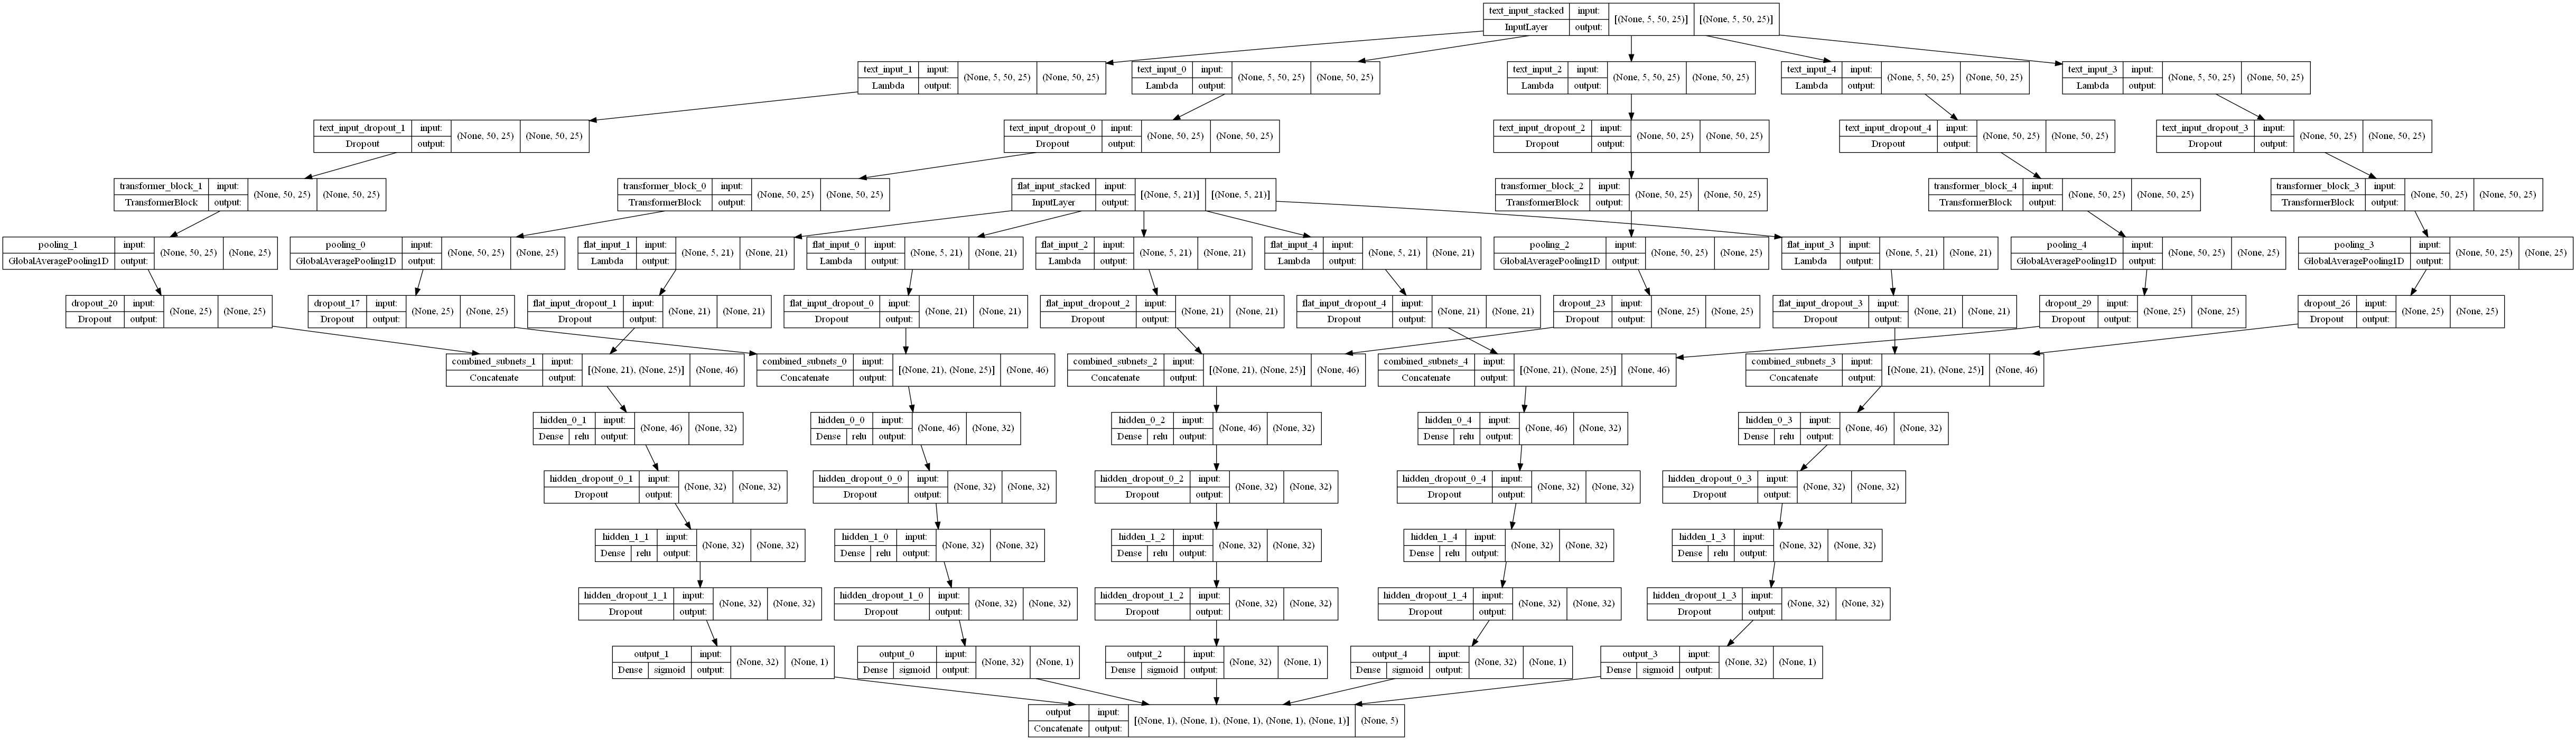

In [6]:
def mean_binary_crossentropy(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    losses = tf.map_fn(
        fn=lambda x: bce(x[0], x[1]),
        elems=[tf.transpose(y_true), tf.transpose(y_pred)],
        fn_output_signature=tf.float32
    )
    return tf.reduce_mean(losses)

def link_up_rl_model(hp, inputs_1, inputs_2, idx=None):
    idx = "" if idx is None else f"_{idx}"
    input_dropout_rate = 0.5 if hp is None else hp.Choice("input_dropout", values=[0.0, 0.1, 0.3, 0.5])
    subnet_1 = inputs_1 if input_dropout_rate == 0 else Dropout(input_dropout_rate, name=f"flat_input_dropout{idx}")(inputs_1)
    subnet_2 = inputs_2 if input_dropout_rate == 0 else Dropout(input_dropout_rate, name=f"text_input_dropout{idx}")(inputs_2)

    l1 = 1e-2 if hp is None else hp.Choice("l1", values=[1e-2, 1e-3, 1e-4])
    l2 = 1e-2 if hp is None else hp.Choice("l2", values=[1e-2, 1e-3, 1e-4])
    reg = L1L2(l1=l1, l2=l2)


    num_heads = 2 if hp is None else hp.Int("num_attn_heads", min_value=1, max_value=8, step=1)
    ff_dim = 32 if hp is None else hp.Int("ff_dim", min_value=32, max_value=128, step=32)
    dropout_rate = 0.5 if hp is None else hp.Choice("transformer_dropout_1", values=[0.0, 0.1, 0.3, 0.5])
    subnet_2 = TransformerBlock(embed_dim=ad_ftrs[1].shape[-1], num_heads=num_heads, ff_dim=ff_dim, rate=dropout_rate, name=f"transformer_block{idx}")(subnet_2)
    subnet_2 = GlobalAveragePooling1D(name=f"pooling{idx}")(subnet_2)
    dropout_rate = 0.5 if hp is None else hp.Choice("transformer_dropout_2", values=[0.0, 0.1, 0.3, 0.5])
    if dropout_rate != 0:
        subnet_2 = Dropout(dropout_rate)(subnet_2)

    output = Concatenate(name=f"combined_subnets{idx}")([subnet_1, subnet_2])

    num_hidden_layers = 2 if hp is None else hp.Int("num_hidden_layers", 1, 3)
    for i in range(num_hidden_layers):
        units = 32 if hp is None else hp.Int(f"units_{i}", min_value=32, max_value=128, step=32)
        output = Dense(units, activation="relu", kernel_regularizer=reg, name=f"hidden_{i}{idx}")(output)
        dropout_rate = 0.5 if hp is None else hp.Choice(f"dropout_{i}", values=[0.0, 0.1, 0.3, 0.5])
        if dropout_rate != 0:
            output = Dropout(dropout_rate, name=f"hidden_dropout_{i}{idx}")(output)

    output = Dense(1, activation="sigmoid", kernel_regularizer=reg, name=f"output{idx}")(output)
    return output

def create_rl_model(hp=None, metrics=[], hypertuning=False, n_users=1):
    assert n_users == 1 or hypertuning

    learning_rate = 1e-2 if hp is None else hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    if hypertuning:
        big_inputs_1 = Input((n_users, ad_ftrs[0].shape[1]+1,), name="flat_input_stacked")
        big_inputs_2 = Input((n_users, *ad_ftrs[1].shape[1:]), name="text_input_stacked")

        outputs = []

        for i in range(n_users):
            inputs_1 = Lambda(lambda x: x[:, i], name=f"flat_input_{i}")(big_inputs_1)
            inputs_2 = Lambda(lambda x: x[:, i], name=f"text_input_{i}")(big_inputs_2)

            output = link_up_rl_model(hp, inputs_1, inputs_2, idx=i)
            outputs.append(output)
        
        output = Concatenate(name="output")(outputs)

        model = Model(inputs=[big_inputs_1, big_inputs_2], outputs=[output, output])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=[mean_binary_crossentropy, "mse"],
            loss_weights=[1,0],
            metrics=metrics
        )
        return model


    else:
        inputs_1 = Input((ad_ftrs[0].shape[1]+1,), name="flat_input")
        inputs_2 = Input(ad_ftrs[1].shape[1:], name="text_input")

        output = link_up_rl_model(hp, inputs_1, inputs_2)

        model = Model(inputs=[inputs_1, inputs_2], outputs=[output])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss="binary_crossentropy",
            metrics=metrics
        )
        return model

def create_rl_model_for_htuning(hp=None):
    return create_rl_model(hp=hp, metrics={"output": "accuracy"}, hypertuning=True, n_users=n_users)

if __name__ == "__main__":
    tuner = tools.HyperbandWithBatchSize(
        create_rl_model_for_htuning,
        objective=kt.Objective("val_output_1_loss", direction="min"),
        max_epochs=100,
        factor=3,
        hyperband_iterations=5,
        directory=os.path.join(logs_dir, "hypertraining"),
        project_name="adgorithm_htuning"
    )

    # print("EXAMPLE MODEL --- HYPERPARAMS NOT TUNED")
    # model = create_rl_model_for_htuning()
    # model.summary()
    # c = tools.ModelDisplayer()
    # c.model = model
    # c.on_epoch_end(0)

In [7]:
if __name__ == "__main__":
    synthetic_user_ftrs = users.generate_synthetic_pca_ftrs(n_users, user_pca_normal_params)
    prod = tools.get_user_ad_ftr_product(synthetic_user_ftrs, ad_ftrs)
    ctr = user_model.predict(prod)
    ctr = ctr.reshape(n_users, n_ads, ctr.shape[-1])
    ctr = (np.argmax(ctr, axis=-1) + 1).astype(float)

    for k, v in rating_to_exp_ctr.items():
        ctr[ctr == k] = v

    ctr = np.broadcast_to(ctr[:,:,np.newaxis], (*ctr.shape, n_rounds))
    num_times_clicked = np.indices(ctr.shape)[-1]
    diminishing_returns = np.power(diminishing_returns_fac, num_times_clicked)
    ctr = ctr * diminishing_returns

    expanded_ad_ftrs = (
        np.broadcast_to(ad_ftrs[0][np.newaxis, :, np.newaxis, :], (n_users, ad_ftrs[0].shape[0], n_rounds, ad_ftrs[0].shape[1])),
        np.broadcast_to(ad_ftrs[1][np.newaxis, :, np.newaxis, :, :], (n_users, ad_ftrs[1].shape[0], n_rounds, *ad_ftrs[1].shape[1:])),
    )

    did_click = np.random.uniform(size=ctr.shape) <= ctr

In [8]:
if __name__ == "__main__":
    train_prop = 0.8
    total_num = n_users*n_ads*n_rounds
    train_num = int(train_prop * total_num)

    # (n_users, n_ads, n_rounds, *FTR_SHAPES)
    X = [np.concatenate([expanded_ad_ftrs[0], num_times_clicked[:,:,:,np.newaxis]], axis=-1), expanded_ad_ftrs[1]]

    # (n_users, n_ads, n_rounds)
    Y = did_click

    # (n_users, n_ads, n_rounds)
    Y_ideal = ctr

    X[0] = np.swapaxes(X[0].reshape((n_users, n_ads*n_rounds, *X[0].shape[3:])), 0, 1)
    X[1] = np.swapaxes(X[1].reshape((n_users, n_ads*n_rounds, *X[1].shape[3:])), 0, 1)

    Y = np.swapaxes(Y.reshape((n_users, n_ads*n_rounds, *Y.shape[3:])), 0, 1)
    Y_ideal = np.swapaxes(Y_ideal.reshape((n_users, n_ads*n_rounds, *Y_ideal.shape[3:])), 0, 1)

    # (n_ads*n_rounds, n_users, *FTR_SHAPES)
    print(X[0].shape)
    print(X[1].shape)
    
    # (n_ads*n_rounds, n_users)
    print(Y.shape)

    # (n_ads*n_rounds, n_users)
    print(Y_ideal.shape)

    X_train, X_test = tools.split_all(X, train_num)
    Y_train, Y_test = Y[:train_num], Y[train_num:]
    Y_ideal_train, Y_ideal_test = Y_ideal[:train_num], Y_ideal[train_num:]

(3000, 5, 21)
(3000, 5, 50, 25)
(3000, 5)
(3000, 5)


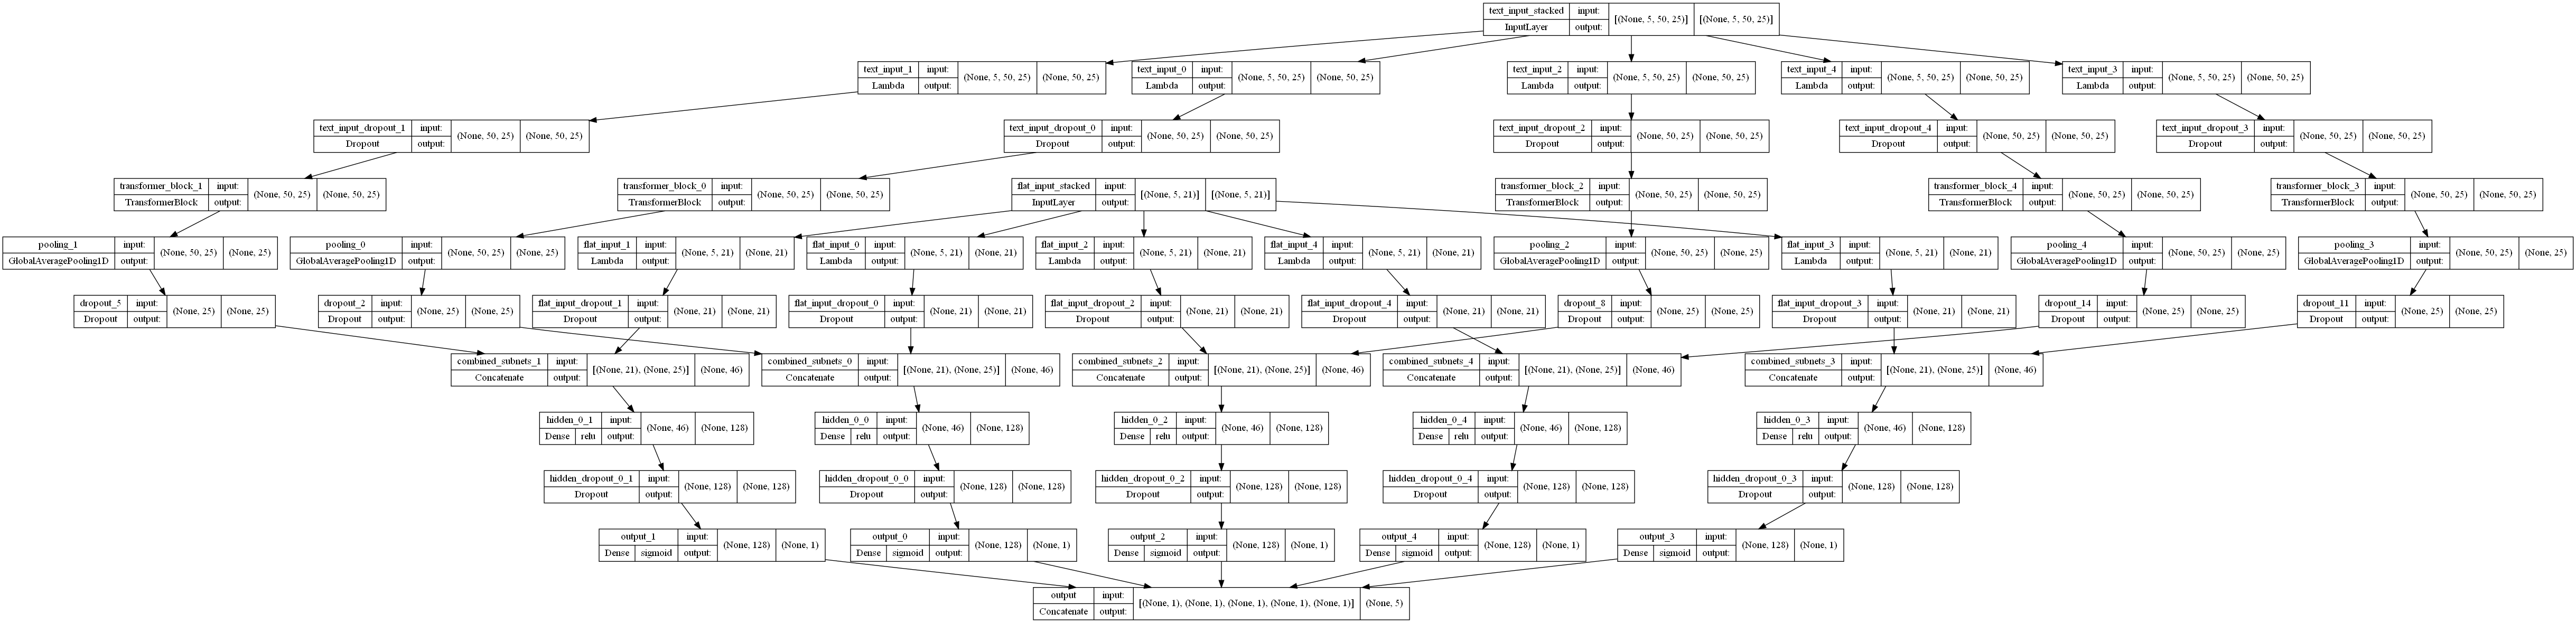

In [9]:
if __name__ == "__main__":
    epochs = 100
    
    try:
        tf.get_logger().setLevel("ERROR")

        params = {
            "verbose": 0,
            "shuffle": True,
            "epochs": epochs
        }


        display(HTML("<h2>HyperTuning</h2>"))
        tuner.search(
            X_train,
            (Y_train, Y_ideal_train),
            **params,
            validation_split=0.2,
            callbacks=[tensorboard_callback, tools.Printer(), tools.ModelDisplayer(), EarlyStopping(monitor='val_loss', mode="min", patience=5)]
        )


        display(HTML("<h2>Found Optimal Model!</h2>"))
        num_trials = 1

        tuner.results_summary(num_trials=num_trials)
        print("\n")
        best_hps=tuner.get_best_hyperparameters(num_trials=num_trials)[0]

        model = tuner.hypermodel.build(best_hps)
        batch_size = best_hps.Int('batch_size', 32, 256, step=32)
        
        # model = create_model()
        # batch_size = 32

        model.summary()

        model.fit(
            X_train,
            Y_train,
            **params,
            batch_size=batch_size,
            validation_data=(X_test,Y_test),
            callbacks=[tensorboard_callback, tools.ModelDisplayer(), tools.Printer(), EarlyStopping(monitor='val_loss', mode="min", patience=10)]
        )

        d.plot_now()

    except KeyboardInterrupt:
        pass